In [1]:
import sys
sys.path.append('../utils')

from preprocessing import Preprocessor

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random
#from sklearn.model_selection import train_test_split  
from sklearn.cross_validation import train_test_split
from PIL import Image

import tensorflow as tf
import tensorflow.contrib.layers as layers
tf.python.control_flow_ops = tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Initialise the data

In [2]:
train_cats, train_dogs, train_all, test_all = Preprocessor.get_dataset_paths()

SEED = 42

random.seed(SEED)
tf.set_random_seed(SEED)

np.random.shuffle(train_all)

labels = [[1., 0.] if 'dog' in name else [0., 1.] for name in train_all] # labels are one hot encoded

## Example of usage

Image: <PIL.Image.Image image mode=RGB size=64x64 at 0x7FBFA22D6BD0>
Lable: [1.0, 0.0]


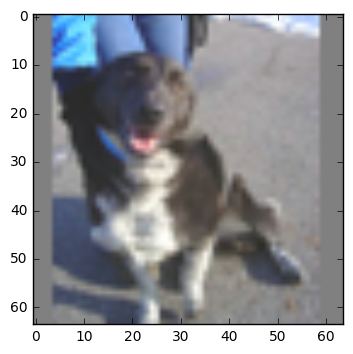

In [3]:
image_size = 64

random_index = np.random.randint(0, len(train_all))
image_path = train_all[random_index]
image = Preprocessor.get_image(image_path)

processed_image = Preprocessor.get_processed_image(image, size=image_size)
print 'Image:', (processed_image)
print 'Lable:', (labels[random_index])
plt.imshow(processed_image)
plt.show()

def get_processed_image_from_path(path):
    image = Preprocessor.get_image(path)
    processed_image = Preprocessor.get_processed_image(image, size=image_size)
    return np.array(processed_image)

In [4]:
print 'Image shape:', (np.array(processed_image).shape)

Image shape: (64, 64, 3)


In [5]:
print np.array(processed_image)[3][0]

[128 128 128]


## Model

In [6]:
from multiprocessing import Pool
import math

In [7]:
dataset_size = 25000
train = list(Pool(8).map(get_processed_image_from_path, train_all[:dataset_size]))
labels = labels[:dataset_size] 

print 'Training picture shape:', train[0].shape
print 'Numbers of training pictures and labels:', len(train), len(labels)

Training picture shape: (64, 64, 3)
Numbers of training pictures and labels: 25000 25000


In [63]:
class TFConvNet(object):
    def __init__(self, feature_num, class_num, step=1e-4, size=64, batch_size=100, weight_decay=0.5):
        self.weight_decay = weight_decay

        self.batch_size = batch_size
        self.feature_num = feature_num
        self.class_num = class_num

        self.X = tf.placeholder(tf.float32, [None, feature_num])
        self.y_ = tf.placeholder(tf.float32, [None, class_num])

        
        with tf.contrib.framework.arg_scope([layers.convolution2d],
            kernel_size=3, stride=1, padding='SAME', activation_fn=tf.nn.relu,
            normalizer_fn=layers.batch_norm,
            weights_initializer=layers.variance_scaling_initializer(),
            weights_regularizer=layers.l2_regularizer(self.weight_decay)
        ):
            self.X = tf.reshape(self.X, [-1, size, size, 3])
            self.keep_prob = tf.placeholder(tf.float32)

            net = layers.convolution2d(self.X, num_outputs=32)
            net = layers.convolution2d(net, num_outputs=32)
            net = layers.max_pool2d(net, kernel_size=2)
            net = layers.relu(net, num_outputs=32)

            net = layers.convolution2d(net, num_outputs=64)
            net = layers.convolution2d(net, num_outputs=64)
            net = layers.max_pool2d(net, kernel_size=2)
            net = layers.dropout(net, keep_prob=self.keep_prob)
            net = layers.relu(net, num_outputs=64)
            
        with tf.contrib.framework.arg_scope([layers.fully_connected],
            activation_fn=tf.nn.relu,
            normalizer_fn=layers.batch_norm,
            weights_initializer=layers.variance_scaling_initializer(),
            weights_regularizer=layers.l2_regularizer(self.weight_decay)
        ):

            net = layers.flatten(net, [-1, 16 * 16 * 64])
            net = layers.fully_connected(net, num_outputs=64)
            net = layers.dropout(net, keep_prob=self.keep_prob)

            
        net = layers.fully_connected(net, num_outputs=self.class_num)
        self.y = layers.softmax(net)

        
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(net, self.y_))
        self.optimizer = tf.train.AdamOptimizer(step).minimize(self.loss)

        pred = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.y_, 1))
        self.acc = tf.reduce_mean(tf.cast(pred, tf.float32))

        self.sess = tf.Session()

    def train(self, X_train, y_train, X_test, y_test, iterations=2000, keep_prob=0.5, batch_test_size=512):
        print("Starting to train")
        self.sess.run(tf.initialize_all_variables())

        batch_size = self.batch_size

        batch_start = 0
        batch_end = batch_start + batch_size

        combined = list(zip(X_train, y_train))
        random.shuffle(combined)
        X_train[:], y_train[:] = zip(*combined)

        batch_test_start = 0
        batch_test_end = batch_test_size
        epoch = 0

        for iteration in range(int(iterations)):
            _, loss, probs = self.sess.run(
                [self.optimizer, self.loss, self.y],
                feed_dict={
                    self.X: X_train[batch_start:batch_end],
                    self.y_: y_train[batch_start:batch_end],
                    self.keep_prob: keep_prob
                }
            )

            if iteration % 1000 == 0:
                train_acc = self.sess.run(
                    self.acc,
                    feed_dict={
                        self.X: X_train[batch_start:batch_end],
                        self.y_: y_train[batch_start:batch_end],
                        self.keep_prob: 1.0
                    }
                )
                
                val_acc, val_loss = self.__get_validation_scores(X_test, y_test, batch_test_size)

                print(
                    '{}({}):, tr_acc: {:.2%}, tr_loss: {:2.6}, val_acc: {:.2%}, val_loss: {:2.5}'.format(
                        iteration, epoch,  train_acc, loss, val_acc, val_loss)
                )

                if val_loss <= 0.2:
                    print('Validation loss is great')
                    break

            batch_start = batch_end
            batch_end += batch_size

            if batch_end > len(X_train):
                epoch += 1
                batch_start = 0
                batch_end = batch_start + batch_size

                combined = list(zip(X_train, y_train))
                random.shuffle(combined)
                X_train[:], y_train[:] = zip(*combined)

        print("Training ended")
        
    def __get_validation_scores(self, X_test, y_test, batch_test_size):
        sum_loss = sum_acc = 0
        for chunk in range(0, len(X_test), batch_test_size):

            start_index = chunk
            end_index = chunk + batch_test_size

            batch_X = X_test[start_index:end_index]
            batch_y = y_test[start_index:end_index]

            batch_val_acc, batch_val_loss = self.sess.run(
                [self.acc, self.loss],
                feed_dict={
                    self.X: batch_X,
                    self.y_: batch_y,
                    self.keep_prob: 1.0}
            )
            sum_acc += batch_val_acc
            sum_loss += batch_val_loss

        num_of_chunks = math.ceil(len(X_test) / batch_test_size)
        val_loss = sum_loss / num_of_chunks
        val_acc = sum_acc / num_of_chunks
        
        return val_acc, val_loss
        
    def generate_submission(self, test_x, file_name='submission.csv'):
        print('Preparing to generate submission.csv')
        predict = self.y

        predictions = []
        for i in range(0, len(test_x)):

            batch = test_x[i * self.batch_size: (i + 1) * self.batch_size]

            if len(batch) == 0:
                break
            
            predict_batch = self.sess.run([predict], feed_dict={self.X: batch, self.keep_prob: 1.0})
            predict_batch = map(lambda x: x[0], predict_batch[0])
            predictions.extend(list(predict_batch))

        print(len(test_x), len(predictions))
        np.savetxt(
            file_name, np.c_[range(1, len(test_x) + 1), predictions],
            delimiter=',', header='id,Label', comments='', fmt='%d,%f'
        )

        print('saved: %s' % file_name)
        
    def predict(self, X):
        image = Preprocessor.get_image(X)
        processed_image = Preprocessor.get_processed_image(image, size=image_size)
        
        plt.imshow(processed_image)
        plt.show()
        
        X_processed = np.array(processed_image).reshape([-1, image_size, image_size, 3])
        predict = self.sess.run([self.y], feed_dict={self.X: X_processed, self.keep_prob: 1.0})
        
        prediction = predict[0][0]
        print prediction
        print 'I think it is a {creature}.'.format(
            creature='dog' if prediction[0] > prediction[1] else 'cat'
        )

# Initialise the model and train

In [64]:
class_num = 2
feature_number = image_size * image_size * 3

train_x, test_x, train_y, test_y = train_test_split(train, labels, test_size=0.3)  

In [65]:
convnet = TFConvNet(
    feature_number,
    class_num,
    size=image_size,
    batch_size=16,
    step=5e-4, 
    weight_decay=100.0
)

In [66]:
convnet.train(
    train_x,
    train_y,
    test_x,
    test_y,
    iterations=3e4,
    keep_prob=0.5,
    batch_test_size=512
)

Starting to train
0(0):, tr_acc: 68.75%, tr_loss: 0.962191, val_acc: 50.04%, val_loss: 0.82983
1000(0):, tr_acc: 75.00%, tr_loss: 0.705116, val_acc: 74.09%, val_loss: 0.60164
2000(1):, tr_acc: 62.50%, tr_loss: 0.65015, val_acc: 80.26%, val_loss: 0.5261
3000(2):, tr_acc: 81.25%, tr_loss: 0.466144, val_acc: 85.96%, val_loss: 0.46799
4000(3):, tr_acc: 81.25%, tr_loss: 0.297091, val_acc: 86.84%, val_loss: 0.4404
5000(4):, tr_acc: 81.25%, tr_loss: 0.517737, val_acc: 90.47%, val_loss: 0.38278
6000(5):, tr_acc: 75.00%, tr_loss: 0.461986, val_acc: 91.62%, val_loss: 0.35621
7000(6):, tr_acc: 100.00%, tr_loss: 0.214528, val_acc: 91.50%, val_loss: 0.35734
8000(7):, tr_acc: 87.50%, tr_loss: 0.239283, val_acc: 93.10%, val_loss: 0.32823
9000(8):, tr_acc: 93.75%, tr_loss: 0.296015, val_acc: 93.44%, val_loss: 0.31854
10000(9):, tr_acc: 81.25%, tr_loss: 0.285358, val_acc: 94.50%, val_loss: 0.2992
11000(10):, tr_acc: 100.00%, tr_loss: 0.167929, val_acc: 94.57%, val_loss: 0.29882
12000(10):, tr_acc: 87.5

# Model generalization exploration

23313


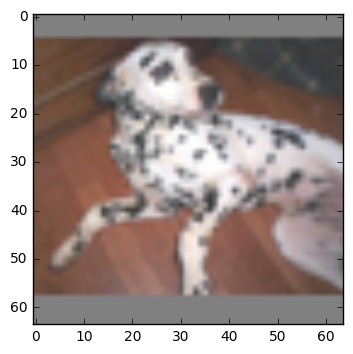

[ 0.48350656  0.51649338]
I think it is a cat.


In [61]:
for i in range(1):
    random_index = np.random.randint(0, len(train_all))
    print random_index
    image_path = train_all[random_index]
    convnet.predict(image_path)

# Process test data

In [33]:
test = list(Pool(8).map(get_processed_image_from_path, test_all))

In [34]:
print 'Test image shape:', test[0].shape

Test image shape: (64, 64, 3)


In [35]:
print test_all[:3]

['../dataset/test/1.jpg', '../dataset/test/2.jpg', '../dataset/test/3.jpg']


# Generate submission

In [67]:
convnet.generate_submission(test)

Preparing to generate submission.csv
(12500, 12500)
saved: submission.csv
